# Keras MNIST classifier with _distributed_ random-search hyper-parameter optimization

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
import os

# External imports
import ipyparallel as ipp
import numpy as np
import matplotlib.pyplot as plt
import keras

# Local imports
from mnist import load_data

Using TensorFlow backend.


## Connect to cluster

Here we use a shell command to query the slurm job ID running our cluster, then we connect using the corresponding cluster ID.

In [2]:
%%bash
squeue -u sfarrell

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          14772843 interacti       sh sfarrell  R       5:13      4 nid000[11-12,22-23]


In [3]:
# Cluster ID taken from job ID above
job_id = 14772843
cluster_id = 'cori_{}'.format(job_id)

# Use default profile
c = ipp.Client(timeout=60, cluster_id=cluster_id)
print('Worker IDs:', c.ids)

Worker IDs: [0, 1, 2, 3]


## Load the data

In [4]:
x_train, y_train, x_test, y_test = load_data()

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10)
y_test shape: (10000, 10)


## Configure the tasks

In [6]:
# Temporarily making things reproducible for development
np.random.seed(0)

# Define the hyper-parameter search points
n_hpo_trials = 32
grid_h1 = np.random.choice([4, 8, 16, 32, 64], size=n_hpo_trials)
grid_h2 = np.random.choice([4, 8, 16, 32, 64], size=n_hpo_trials)
grid_h3 = np.random.choice([8, 16, 32, 64, 128], size=n_hpo_trials)
grid_dropout = np.random.rand(n_hpo_trials)
grid_optimizer = np.random.choice(['Adadelta', 'Adam', 'Nadam'], size=n_hpo_trials)

# Training config
batch_size = 128
n_epochs = 16
valid_frac = 0.17
checkpoint_dir = os.path.join(os.environ['SCRATCH'],
                              'cori-interactive-dl/mnist_hpo_%i' % job_id)
os.makedirs(checkpoint_dir, exist_ok=True)

## Run the trainings

In [7]:
def build_and_train(valid_frac, batch_size, n_epochs,
                    h1, h2, h3, dropout, optimizer, verbose=0,
                    checkpoint_file=None):
    """Run training for one set of hyper-parameters"""
    import keras
    from mnist import build_model, load_data
    from mlextras import configure_session, IPyParallelLogger
    # Load the data
    x_train, y_train, _, _ = load_data()
    # Thread settings
    keras.backend.set_session(configure_session())
    # Build the model
    model = build_model(h1=h1, h2=h2, h3=h3,
                        dropout=dropout, optimizer=optimizer)
    callbacks = []
    if checkpoint_file is not None:
        callbacks.append(keras.callbacks.ModelCheckpoint(checkpoint_file))
    # Train the model
    history = model.fit(x_train, y_train,
                        validation_split=valid_frac,
                        batch_size=batch_size, epochs=n_epochs,
                        verbose=verbose, callbacks=callbacks)
    return history.history

In [8]:
# Load-balanced view
lv = c.load_balanced_view()

# Loop over hps
results = []
params = zip(grid_h1, grid_h2, grid_h3, grid_dropout, grid_optimizer)
for ihp, (h1, h2, h3, dropout, optimizer) in enumerate(params):
    print('HP trial %i hidden %i-%i-%i dropout %.3f opt %s' %
          (ihp, h1, h2, h3, dropout, optimizer))
    checkpoint_file = os.path.join(checkpoint_dir, 'model_%i.h5' % ihp)
    result = lv.apply(build_and_train,
                      valid_frac=valid_frac,
                      batch_size=batch_size, n_epochs=n_epochs,
                      h1=h1, h2=h2, h3=h3,
                      dropout=dropout, optimizer=optimizer,
                      checkpoint_file=checkpoint_file, verbose=2)
    results.append(result)

HP trial 0 hidden 64-8-128 dropout 0.020 opt Nadam
HP trial 1 hidden 4-8-16 dropout 0.442 opt Nadam
HP trial 2 hidden 32-8-32 dropout 0.980 opt Adadelta
HP trial 3 hidden 32-4-128 dropout 0.359 opt Adadelta
HP trial 4 hidden 32-16-64 dropout 0.481 opt Adadelta
HP trial 5 hidden 8-64-128 dropout 0.689 opt Adam
HP trial 6 hidden 32-32-128 dropout 0.880 opt Nadam
HP trial 7 hidden 16-32-128 dropout 0.918 opt Adadelta
HP trial 8 hidden 64-16-64 dropout 0.217 opt Adadelta
HP trial 9 hidden 4-64-128 dropout 0.565 opt Adam
HP trial 10 hidden 4-16-128 dropout 0.865 opt Adadelta
HP trial 11 hidden 64-4-128 dropout 0.509 opt Nadam
HP trial 12 hidden 16-4-8 dropout 0.917 opt Adam
HP trial 13 hidden 8-64-128 dropout 0.921 opt Adam
HP trial 14 hidden 4-4-64 dropout 0.083 opt Adam
HP trial 15 hidden 8-64-32 dropout 0.278 opt Adadelta
HP trial 16 hidden 8-8-8 dropout 0.009 opt Adadelta
HP trial 17 hidden 4-64-16 dropout 0.842 opt Adadelta
HP trial 18 hidden 8-8-16 dropout 0.647 opt Adam
HP trial 19 h

In [16]:
print('Tasks completed: %i / %i' % (np.sum([ar.ready() for ar in results]), len(results)))

Tasks completed: 32 / 32


In [17]:
ar = results[1]

In [18]:
print(ar.stdout)

Train on 49800 samples, validate on 10200 samples
Epoch 1/16
 - 4s - loss: 0.9735 - acc: 0.6570 - val_loss: 0.2224 - val_acc: 0.9453
Epoch 2/16
 - 3s - loss: 0.6163 - acc: 0.7772 - val_loss: 0.1457 - val_acc: 0.9619
Epoch 3/16
 - 3s - loss: 0.5427 - acc: 0.8060 - val_loss: 0.2042 - val_acc: 0.9417
Epoch 4/16
 - 3s - loss: 0.4972 - acc: 0.8239 - val_loss: 0.1097 - val_acc: 0.9688
Epoch 5/16
 - 3s - loss: 0.4634 - acc: 0.8380 - val_loss: 0.1055 - val_acc: 0.9699
Epoch 6/16
 - 3s - loss: 0.4471 - acc: 0.8444 - val_loss: 0.0932 - val_acc: 0.9748
Epoch 7/16
 - 3s - loss: 0.4285 - acc: 0.8516 - val_loss: 0.0898 - val_acc: 0.9756
Epoch 8/16
 - 3s - loss: 0.4236 - acc: 0.8522 - val_loss: 0.0913 - val_acc: 0.9749
Epoch 9/16
 - 3s - loss: 0.4149 - acc: 0.8560 - val_loss: 0.0845 - val_acc: 0.9765
Epoch 10/16
 - 3s - loss: 0.3998 - acc: 0.8581 - val_loss: 0.0791 - val_acc: 0.9780
Epoch 11/16
 - 3s - loss: 0.3996 - acc: 0.8624 - val_loss: 0.0798 - val_acc: 0.9774
Epoch 12/16
 - 3s - loss: 0.3945 - 

In [19]:
histories = [ar.get() for ar in results]

## Model selection and evaluation

In [20]:
last_scores = np.array([h['val_acc'][-1] for h in histories])
best_scores = np.array([max(h['val_acc']) for h in histories])

### Best model

In [23]:
%matplotlib inline

Hyperparameters: trial 24 hidden 16-8-128 dropout 0.370 opt Adam
  Last validation accuracy 0.9903
  Best validation accuracy 0.9911


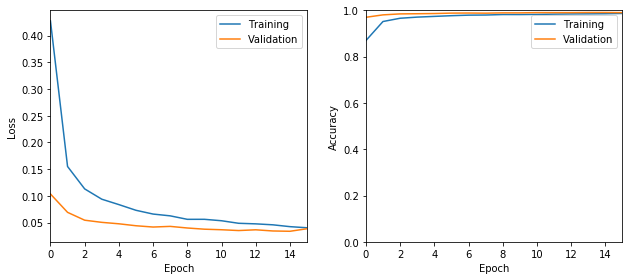

In [24]:
# Find the best in terms of final validation set accuracy
i = best_scores.argmax()
h = histories[i]

print('Hyperparameters: trial %i hidden %i-%i-%i dropout %.3f opt %s' %
      (i, grid_h1[i], grid_h2[i], grid_h3[i], grid_dropout[i], grid_optimizer[i]))
print('  Last validation accuracy %.4f' % last_scores[i])
print('  Best validation accuracy %.4f' % best_scores[i])

plt.figure(figsize=(9,4))

# Loss
plt.subplot(121)
plt.plot(h['loss'], label='Training')
plt.plot(h['val_loss'], label='Validation')
plt.xlim(xmin=0, xmax=len(h['loss'])-1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

# Accuracy
plt.subplot(122)
plt.plot(h['acc'], label='Training')
plt.plot(h['val_acc'], label='Validation')
plt.xlim(xmin=0, xmax=len(h['loss'])-1)
plt.ylim((0, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.tight_layout()

### Worst model

Hyperparameters: trial 2 hidden 32-8-32 dropout 0.980 opt Adadelta
  Last validation accuracy 0.1066
  Best validation accuracy 0.1066


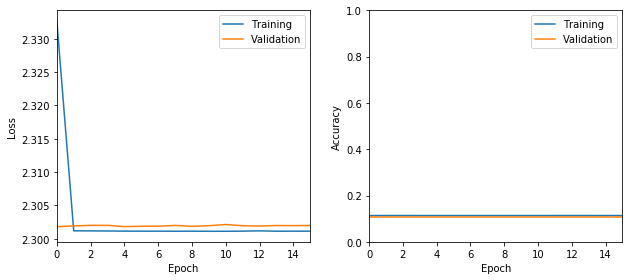

In [25]:
# Find the best in terms of final validation set accuracy
i = best_scores.argmin()
h = histories[i]

print('Hyperparameters: trial %i hidden %i-%i-%i dropout %.3f opt %s' %
      (i, grid_h1[i], grid_h2[i], grid_h3[i], grid_dropout[i], grid_optimizer[i]))
print('  Last validation accuracy %.4f' % last_scores[i])
print('  Best validation accuracy %.4f' % best_scores[i])

plt.figure(figsize=(9,4))

# Loss
plt.subplot(121)
plt.plot(h['loss'], label='Training')
plt.plot(h['val_loss'], label='Validation')
plt.xlim(xmin=0, xmax=len(h['loss'])-1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

# Accuracy
plt.subplot(122)
plt.plot(h['acc'], label='Training')
plt.plot(h['val_acc'], label='Validation')
plt.xlim(xmin=0, xmax=len(h['loss'])-1)
plt.ylim((0, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.tight_layout()

### Test set evaluation

Here we load the best selected model and evaluate final performance on the test set.

In [26]:
i = best_scores.argmax()
model_file = os.path.join(checkpoint_dir, 'model_%i.h5' % i)
model = keras.models.load_model(model_file)

In [27]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

In [28]:
print('Test loss: %.4f' % test_loss)
print('Test accuracy: %.4f' % test_acc)

Test loss: 0.0309
Test accuracy: 0.9897
